## Emotionserkennung von EKG-Daten mit den CNN-, LSTM- und CNN-LSTM Modelle und der Einfluss der Benutzerabhängigkeit darauf

In dieser Arbeit wurde versucht, eine Methode zu bestimmen, um die Schläfrigkeit eines Studenten während des Online-Lernens zu erkennen. Aufgrund der Corona-Pandemie wurden Bildungseinrichtungen in vielen Ländern geschlossen, um den Kontakt der Menschen zueinander zu verringern. Fast jede Institution musste ihren Ausbildungsprozess auf das Internet verlagern. Das Lernen online war für viele ungewohnt und verursachte häufig den Abbruch nonverbaler Kommunikation zwischen dem Dozenten und den Studenten. Deswegen war der Dozent nicht mehr in der Lage, den Unterricht abhängig vom Gefühlszustand der Studenten zu modifizieren. Das führte sowohl für den Lehrer als auch für die Studenten zu Zeit- und Informationsverlust. Um die Schläfrigkeit zu erkennen und so den Student und den Dozenten zu warnen, wurde in dieser Arbeit der Stand der Technik recherchiert und miteinander verglichen.

Die Anzahl von Menschen, die alltaglich ein Smartwatch verwenden, steigt regelmäßig auf, und durch manche Smartwatches ist es möglich, die EKG-Daten eines Menschen ohne zusätzliche Geräte einfach zu erfassen.
Die Gefühlen, wie z.B. die Langeweile, kann einen in die Schläfrigkeit führen und als eine mögliche Ursache angenommen werden. Wegen geringer Anzahl von öffentlichen Datensätzen mit EKG-Daten zur Schläfrigkeitserkennung wurde diese Arbeit sich in die Richtung von der Gefühlserkennung durch EKG-Daten verschoben. Um die Verwendung eines Biofeedbacksystems in der Zukunft zu ermöglichen, wurde ein Vergleich des 1D CNN-LSTM-Modells mit einem CNN- und einem LSTM-Modell zur Emotionserkennung anhand von zwei verschiedenen Protokollen untersucht. Die Leistung jedes Modells wurde auf der Grundlage der Verteilung von Trainings- und Testdaten untersucht. Im ersten Protokoll wurden die EKG-Daten nach dem Zufallsprinzip als Trainings- und Testdaten aufgeteilt, dann basierend auf den Teilnehmern. Das vorgeschlagene 1D-CNN-LSTM-Modell erzielte eine Testgenauigkeit von 90 \% für das benutzerabhängige Experiment, während die Genauigkeit für das benutzerunabhängige Experiment 33 \% betrug. Das einfach konzipierte CNN-Modell erreichte 80 \% bzw. 33 \%. Ein ähnliches LSTM-Modell lieferte 60 \% bzw. 34 \% Testgenauigkeit. Abschließend wurden mögliche zukünftige Arbeiten diskutiert, um unausgewogene Datensätze und Overfitting-Probleme zu behandeln.

### Die Vorbereitung der Umgebung und das Importieren der benötigten Bibliotheke

In [ ]:
#Install Neurokit 2
!pip install https://github.com/neuropsychology/neurokit/zipball/master

# Load the TensorBoard notebook extension
%load_ext tensorboard

     / 155.9 MB 1.3 MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for neurokit2: filename=neurokit2-0.1.4.1-py2.py3-none-any.whl size=1024121 sha256=4933223b50e55f3a5f05c562ef2b4fc90994afe93c0dff8d63c5545d405f5bf8
  Stored in directory: /tmp/pip-ephem-wheel-cache-40o9gt6v/wheels/f9/ab/f2/fd4a1736f76af31efe92b48862a9b15d383fd35cebc6010ed5
Successfully built neurokit2


In [ ]:
import os
import copy
import random
import datetime
import scipy.io
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from numpy.random import seed
import tensorflow as tf
from tensorflow import keras, random
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

## Helferfunktionen

### Helferfunktionen für Dateibearbeitung


In [ ]:
def construct_file(file_as_dict):
  """
  Wandelt die vom Mat-File eingelesene Daten ins bestimmten Wörterbuchformat um.
  Inputs: 
    file_as_dict: Aus dem Mat-File eingelesene Daten im Wörterbuchformat
  Outputs:
    subject_dict: Daten vom Input als oben vorgestelltes Wörtebuchformat
  """

  subject_dict = {}
  for subject_index in range(file_as_dict["Data"][0].shape[0]):
    experiment_dict = {}
    for experiment in range(18): ## 18 experiments are made
      experiment_dict[experiment] = {
        "baseline": {"channel_1": file_as_dict["Data"][0][subject_index][0][0]["ECG"][0][0]["baseline"][experiment][0].T[0],
                      "channel_2": file_as_dict["Data"][0][subject_index][0][0]["ECG"][0][0]["baseline"][experiment][0].T[1]},
        "stimuli": {"channel_1": file_as_dict["Data"][0][subject_index][0][0]["ECG"][0][0]["stimuli"][experiment][0].T[0],
                    "channel_2": file_as_dict["Data"][0][subject_index][0][0]["ECG"][0][0]["stimuli"][experiment][0].T[1]}
      }
      subject_dict[subject_index] = {"experiments":experiment_dict}
  return subject_dict

def load_file(file_path):
  """
  Liest das Mat-File ein und wandelt es in einem bestimmten Format um.
  Inputs:
    file_path: Dateipfade vom Mat-File
  Outputs:
    file_as_dict: Eingelesene Mat-File als Wörterbuchformat
    consturcted_file: Daten vom Input als oben vorgestelltes Wörtebuchformat mittels der Funktion construct_file()
  """
  with open(file_path,'r') as f:
    data_file =  scipy.io.loadmat(file_path)
    file_as_dict = {"Data" : data_file["DREAMER"][0][0][0],
                "ECG_sampling_rate": data_file["DREAMER"][0][0][2],
                "no_of_subjects": data_file["DREAMER"][0][0][4],
                "no_of_video_seq": data_file["DREAMER"][0][0][5]
                }
    constructed_file = construct_file(file_as_dict)
    return file_as_dict, constructed_file

def read_output_from_mat(file_path):
  """
  Liest die Ausgaben vom im Matlab entwickelten Modell vom Mat-Datei ein und
  extrahiert die Test- und Train-Vorhersagen und dementsprechend echte Beschriftungen.
  Inputs:
    file_path: Dateipfad vom Mat-Datei
  Outputs:
    train_pred: Vorhersagen der Traindaten
    train_target: Ecte Beschriftungen der Traindaten
    test_pred: Vorhersagen der Testdaten
    test_target: Ecte Beschriftungen der Testdaten
  """
  output_file = scipy.io.loadmat(file_path)
  train_out = output_file['combined_outputs'][0][0]
  test_out = output_file['combined_outputs'][0][1]
  train_pred, train_target = sep_pred_target(train_out)
  test_pred, test_target = sep_pred_target(test_out)
  return train_pred, train_target, test_pred, test_target 

def split_pred_target(out_arr):
  """
  Teilt Vorgersagen und echte Beschriftungen voneinander
  Inputs:
    out_arr: Array, das die Vorhersagen und echte Beschriftungen zusammen beinhaltet
  Outputs:
    pred_list: Die Liste der Vorhersagen
    target_list: Die Liste der echten Beschriftungen
  """
  pred_list = []
  target_list = []
  for idx in range(len(out_arr)):
    pred_list.append(out_arr[idx][0].item())
    target_list.append(out_arr[idx][1].item())
  return pred_list, target_list

def save_as_mat(labeled_dict, file_path):
  """
  Strukturiert das Wörterbuch so um, dass es in einem Mat-Datei für die Exportierung eingeschrieben werden kann
  Inputs:
    labeled_dict: Wörterbuch mit vorverarbeiteten Daten und Beschriftungen
    file_path: Dateipfad mit Dateiname
  """
  subjects_list = []
  for subject in labeled_dict:
    subject_experiments_dict = labeled_dict[subject]["experiments"]
    experiments_list = []
    for experiment in subject_experiments_dict:
      segments_dict = subject_experiments_dict[experiment]["stimuli"]["segments"]
      label = subject_experiments_dict[experiment]["stimuli"]["label"]
      segments_list = []
      for segment in segments_dict:
        segments_list.append(segments_dict[segment])
      segment_list_object = turn_into_npobject(segments_list)
      experiments_list.append(np.array([segment_list_object, label]))
    experiment_list_object = turn_into_npobject(experiments_list)
    subjects_list.append(experiment_list_object)
  data_to_savemat = turn_into_npobject(subjects_list)
  scipy.io.savemat(file_path, {"Data":data_to_savemat})

def turn_into_npobject(data_list):
  """
  Wandelt das Liste-Format ins Objektliste-Format um.
  Inputs:
    data_list: Die Liste, die umgewandelt wird
  Outputs:
    data_stack: Die Objektliste
  """
  data_stack = np.empty((len(data_list),), dtype=np.object)
  for i in range(len(data_list)):
      data_stack[i] = data_list[i]
  return data_stack

### Helferfunktionen für Signalbearbeitung

In [ ]:
def segment_stimuli_signal_from_end(subject_dict, length, sampling_rate, offset):
  """
  Segmentiert die bestimmte Reihe von Stimulidaten vom Ende, als Versatz + Länge + Versatz.
  Inputs:
    subject_dict: Vom Mat-File aufgebautes Wörterbuch
    length: Segmentlänge, als Sekunde
    sampling_rate: Signalabtastrate
    offset: Zusätzliche Länge(Versatz), die vor und nach der Segmentlänge hinzugefügt wird. Als Sekunde.
  Outputs:
    shortened_record_dict: Ähnlich mit dem Input subject_dict, aber mit dem verkürzten Stimulisignale für beide Kanäle
  """
  signal_length = length * sampling_rate + 2 * offset * sampling_rate
  shortened_record_dict = copy.deepcopy(subject_dict)
  for subject in subject_dict:
    for experiments in subject_dict[subject]["experiments"]:
      stimuli_signal_ch1 = subject_dict[subject]["experiments"][experiments]["stimuli"]["channel_1"][-signal_length:]
      stimuli_signal_ch2 = subject_dict[subject]["experiments"][experiments]["stimuli"]["channel_2"][-signal_length:]
      shortened_record_dict[subject]["experiments"][experiments]["stimuli"]["channel_1"] = stimuli_signal_ch1
      shortened_record_dict[subject]["experiments"][experiments]["stimuli"]["channel_2"] = stimuli_signal_ch2
  return shortened_record_dict

def downsampling_ecg_signals(datafile, channel, sampling_rate, desired_sampling_rate):
  """
  Ändert die Abtastrate durch Downsampling.
  Inputs:
    datafile: Daten als Wörterbuchformat, die die Signaldaten beinhaltet. Z.B. Ausgabe von segment_stimuli_signal_from_end()
    channel: Der Signalkanal, dessen Abtastrate verändert wird. Es ist entweder 1 oder 2
    sampling_rate: Signalabtastrate
    desired_sampling_rate: Gewünschte Signalabtastrate
  Outputs:
    resampled_signal_dict: Ähnlich mit dem Input datafile, aber mit den Signalen mit neuer Abtastrate
  """
  resampled_signal_dict = copy.deepcopy(datafile)
  selected_channel = "channel_" + str(channel)
  for subject in datafile:
    for experiments in datafile[subject]["experiments"]:
      baseline_signal = datafile[subject]["experiments"][experiments]["baseline"][selected_channel]
      stimuli_signal = datafile[subject]["experiments"][experiments]["stimuli"][selected_channel]
      resampled_baseline_signal = nk.signal_resample(signal=baseline_signal, sampling_rate=sampling_rate, desired_sampling_rate=desired_sampling_rate)
      resampled_stimuli_signal = nk.signal_resample(signal=stimuli_signal, sampling_rate=sampling_rate, desired_sampling_rate=desired_sampling_rate)
      resampled_signal_dict[subject]["experiments"][experiments]["baseline"][selected_channel] = resampled_baseline_signal
      resampled_signal_dict[subject]["experiments"][experiments]["stimuli"][selected_channel] = resampled_stimuli_signal
  return resampled_signal_dict

def apply_lowpass_filer(downsampled_dict, channel, sampling_rate, highcut):
  """
  Filtert die Signale mit dem Tiefpass-Filter nach dem Highcut, um das hochfrequente Geräusch wegzuwerfen.
  Inputs:
    downsampled_dict: Wörterbuch mit Signaldaten, z.B. die Ausgabe von Funktion downsampling_ecg_signals()
    channel: Der Signalkanal, deren Signale mit dem Tiefpass-Filter gefiltert wird. Es ist entweder 1 oder 2.
    sampling_rate: Signalabtastrate
    highcut: Oberer Cutoff-Grenze
  Outputs:
    lowwpass_filtered_signal_dict: Wörterbuch mit gefilterten Signalen
  """
  lowpass_filtered_signal_dict = copy.deepcopy(downsampled_dict)
  selected_channel = "channel_" + str(channel)
  for subject in downsampled_dict:
    for experiments in downsampled_dict[subject]["experiments"]:
      baseline_signal = downsampled_dict[subject]["experiments"][experiments]["baseline"][selected_channel]
      stimuli_signal = downsampled_dict[subject]["experiments"][experiments]["stimuli"][selected_channel]
      lowpass_filtered_baseline_signal = nk.signal_filter(signal=baseline_signal, sampling_rate=sampling_rate, highcut=highcut)
      lowpass_filtered_stimuli_signal = nk.signal_filter(signal=stimuli_signal, sampling_rate=sampling_rate, highcut=highcut)
      lowpass_filtered_signal_dict[subject]["experiments"][experiments]["baseline"][selected_channel] = lowpass_filtered_baseline_signal
      lowpass_filtered_signal_dict[subject]["experiments"][experiments]["stimuli"][selected_channel] = lowpass_filtered_stimuli_signal
  return lowpass_filtered_signal_dict

def remove_filter_effect_by_edgecutting(filtered_dict, offset, sampling_rate):
  """
  Entfernt den Versatzteil von den Signalen, um den Start- und Endeffekt vom Filter überzuwinden.
  Inputs:
    filtered_dict: Wörterbuch mit Signalen
    offset: Der Versatzlänge zum Entfernen, als Sekunde
    sampling_rate: Signalabtastrate
  Outputs:
    shortened_filtered_dict: Ähnlich mit dem Input filtered_dict, aber mit verkürzten Signalen
  """
  shortened_filtered_dict = copy.deepcopy(filtered_dict)
  edgecut_length = offset * sampling_rate
  for subject in filtered_dict:
    for experiments in filtered_dict[subject]["experiments"]:
      baseline_signal_ch1 = filtered_dict[subject]["experiments"][experiments]["baseline"]["channel_1"][edgecut_length:-edgecut_length]
      baseline_signal_ch2 = filtered_dict[subject]["experiments"][experiments]["baseline"]["channel_2"][edgecut_length:-edgecut_length]
      stimuli_signal_ch1 = filtered_dict[subject]["experiments"][experiments]["stimuli"]["channel_1"][edgecut_length:-edgecut_length]
      stimuli_signal_ch2 = filtered_dict[subject]["experiments"][experiments]["stimuli"]["channel_2"][edgecut_length:-edgecut_length]
      shortened_filtered_dict[subject]["experiments"][experiments]["baseline"]["channel_1"] = baseline_signal_ch1
      shortened_filtered_dict[subject]["experiments"][experiments]["baseline"]["channel_2"] = baseline_signal_ch2
      shortened_filtered_dict[subject]["experiments"][experiments]["stimuli"]["channel_1"] = stimuli_signal_ch1
      shortened_filtered_dict[subject]["experiments"][experiments]["stimuli"]["channel_2"] = stimuli_signal_ch2
  return shortened_filtered_dict

def get_segmented_dict(data_dict, sampling_rate, length_of_segment, channel, get_mean=True):
  """
  Segmentiert die Signale und (falls get_mean is "True") rechnet ihren Durchschnittswert.
  Inputs:
    data_dict: Wörberbuch mit Signalen, z.B. die Ausgabe von Funktion remove_filter_effect_by_edgecutting()
    sampling_rate: Signalabtastrate
    length_of_segment: Segmentlänge als Sekunde
    channel: Der Signalkanal, dessen Signale segmentiert werden. Es ist entweder 1 oder 2.
    get_mean: Boolean, das bestimmt, ob das Durchschnittssegment berechnet wird.
  Outputs:
    segmented_dict: Ähnlich mit dem Input data_dict, aber mit Segmenten und kann auch Durchschnittssegment beinhalten.
  Neuer Struktur vom Wörterbuch:
    segmented_dict = {
    subject_index: {
      "experiments": {
        experiment_index: {
          "baseline": {
            "channel_1": [ecg_data_as_array]
            "channel_2": [ecg_data_as_array]
            "segments": {
              "segment_1": [ecg_data_as_array_mit_segment_länge]
              ...
              ...
              ...
            }
          }
          "stimuli": {
            "channel_1": [ecg_data_as_array]
            "channel_2": [ecg_data_as_array]
            "segments": {
              "segment_1": [ecg_data_as_array_mit_segment_länge]
              ...
              ...
              ...
            }
          }
        }
      }
    }
  }
  """
  segmented_dict = copy.deepcopy(data_dict)
  selected_channel = "channel_" + str(channel)
  for subject in data_dict:
    for experiments in data_dict[subject]["experiments"]:
      baseline_signals = segmented_dict[subject]["experiments"][experiments]["baseline"]
      baseline_signals["segments"] = segment_signal(baseline_signals[selected_channel], sampling_rate=sampling_rate,
                                                              length=length_of_segment)
      stimuli_signals = segmented_dict[subject]["experiments"][experiments]["stimuli"]
      stimuli_signals["segments"] = segment_signal(stimuli_signals[selected_channel], sampling_rate=sampling_rate,
                                                              length=length_of_segment)
      if get_mean:
        baseline_signals["mean_segment"] = get_mean_of_segments(baseline_signals["segments"])
  return segmented_dict

def segment_signal(signal, sampling_rate, length):
  """
  Segmentiert einem Signal
  Inputs:
    signal: Signal als Array zur Segmentierung
    sampling_rate: Signalabtastrate
    length: Segmentlänge als Sekunde
  Outputs:
    segment_dict: Wörterbuch mit Signalsegmenten
  Struktur vom segment_dict:
  {
    "segment_1" : [ecg_segment_as_array]
    "segment_2" : [ecg_segment_as_array]
    ...
    ...
    ...
  }
  """
  segment_dict = {}
  segment_length = sampling_rate*length
  segment_count = int(signal.shape[0]/segment_length)
  start_index = 0
  for segment_index in range(segment_count):
    end_index = start_index + segment_length
    segment_dict["segment_"+str(segment_index)] = signal[start_index:end_index]
    start_index = end_index
  return segment_dict

def get_mean_of_segments(segment_dict):
  """
  Addiert alle Segmente zu und teilt das Ergebniss mit der Segmentenanzahl
  Inputs:
    segment_dict: Wörterbuch, das die Segmente beinhaltet. Z.B. die Ausgabe von Funktion segment_signal()
  Outputs:
    mean_segment: Durchschnittssegment
  Beispiel:
    segment_1 = [1,2,3,4], segment_2 = [3,2,3,4] --> sum(segment_1, segment_2) = [4,4,6,8]
    Weil es zwei Segmente gibt, ist die Segmentanzahl 2. 
    Dann, sum(segment_1, segment_2) / segmentanzahl = [4,4,6,8] / 2 = [2,2,3,4] ist das Durchschnittssegment  
  """
  temp_segments = []
  for key in segment_dict:
    temp_segments.append(segment_dict[key])
  mean_segment = np.sum(temp_segments, axis=0) / len(segment_dict.keys())
  return mean_segment

def remove_baseline_from_stimuli(segmented_dict, channel):
  """
  Subtrahiert das Durchschnittssegment von allen Signalsegmente.
  Inputs: 
    segmented_dict: Wörterbuch mit segmentierten Signalen. Z.B. die Ausgabe von Funktion get_segmented_dict() mit get_mean = True
    channel: Der Signalkanal, deren Signale segmentiert wurden und von deren Signale die Grundlinie (Baseline) subtrahiert wird.
             Es ist entweder 1 oder 2.
  Outputs:
    baseline_removed_dict: Mit dem Input segmented_dict ähnliches Wörterbuch, mit Grundlinie von sich extrahierten Signalen 
  """
  baseline_removed_dict = copy.deepcopy(segmented_dict)
  selected_channel = "channel_" + str(channel)
  for subject in segmented_dict:
    for experiments in segmented_dict[subject]["experiments"]:
      computed_mean_baseline = baseline_removed_dict[subject]["experiments"][experiments]["baseline"]["mean_segment"]
      stimuli_signal_segments = baseline_removed_dict[subject]["experiments"][experiments]["stimuli"]["segments"]
      for stimuli_segment in stimuli_signal_segments:
        stimuli_signal_segments[stimuli_segment] = np.subtract(stimuli_signal_segments[stimuli_segment], computed_mean_baseline)
  return baseline_removed_dict

def standardize_stimuli_signals(segmented_dict):
  """
  Führt die Z-Score-Normalisierung(Standardizierung) auf den Signalen mittels des StandartScalers durch.
  Inputs: 
    segmented_dict: Wörterbuch mit segmentierten Signalen
  Outputs: 
    standardized_dict: Wörterbuch ähnlich mit dem Input segmented_dict,
                       aber mit standardizierten Signalen
  """
  standardized_dict = copy.deepcopy(segmented_dict)
  scaler = StandardScaler()
  for subject in segmented_dict:
    for experiments in segmented_dict[subject]["experiments"]:
      stimuli_signal_segments = standardized_dict[subject]["experiments"][experiments]["stimuli"]["segments"]
      for segment in stimuli_signal_segments:
        reshaped_segment = segment_to_2d_array(stimuli_signal_segments[segment])
        scaler.fit(reshaped_segment)
        stimuli_signal_segments[segment] = scaler.transform(reshaped_segment)
  return standardized_dict

def segment_to_2d_array(segment):
  """
  Wandelt die Signalen um 2-dimensionales Format für die Standardizierung um.
  Inputs:
    segment: Ein Signalsegment als Array
  Outputs:
    new_segment: Ein Signalsegment mit der neuen Größe
  """
  new_segment = np.reshape(segment, (segment.shape[0],1))
  return new_segment

def label_segments(preprocessed_dict, file_as_dict, threshold=3):
  """
  Beschrift die Daten mit deren entsprechenden Erregung- (Arousal) und Valenzwerte (Valence) im Bezug auf Schwellwert
  Inputs:
    preprocessed_dict: Wörterbuch nach den Vorbereitungsprozesse
    file_as_dict: Rohdatei, wie gelesen vom File mit Funktion load_file()
    threshold: Die Erregung- und Valenzwerte weichen zwischen 0 bis 5 ab. Ab dem Threshold werden die Merkmale
               als hoch und bis dem Threshold werden sie als niedrig beschriftet.
               Beispiel: Erregungswert = 5, Valenzwert = 2, dann die Beschriftung = "HALV" = Höhe Erregung, Niedrige Valenz
  Outputs:
    label_set: Die Liste von den Beschriftungen
    labeled_dict: Wörterbuch mit Signalen und Beschriftungen
  Neue Struktur:
    subject_index: {
        "experiments": {
          experiment_index: {
            "baseline": ...
            }
            "stimuli": {
              "channel_1": ...
              "channel_2": ...
              "segments": ...
              "label" = "selected_label_as_string"
              }
            }
          }
        }
      }
    }
  """
  label_set = ["HAHV","HALV", "LAHV", "LALV"]
  labeled_dict = copy.deepcopy(preprocessed_dict)
  for subject in preprocessed_dict:
    subject_valence_ratings = file_as_dict["Data"][0][subject][0][0]["ScoreValence"]
    subject_arousal_ratings = file_as_dict["Data"][0][subject][0][0]["ScoreArousal"]
    experiment_dict = labeled_dict[subject]["experiments"]
    for experiment in experiment_dict:
      label = select_label(arousal_score = subject_arousal_ratings[experiment][0],
                           valence_score = subject_valence_ratings[experiment][0],
                           threshold = threshold)
      stimuli_dict = experiment_dict[experiment]["stimuli"]
      stimuli_dict["label"] = label
  return label_set, labeled_dict

def select_label(arousal_score, valence_score, threshold):
  """
  Bestimmt die Beschriftung im Bezug auf Schwellwert
  Inputs:
    arousal_score: Die Erregungswert vom Sample
    valence_score: Die Valenzwert vom Sample
    threshold: Schwellwert wie in der Funktion label_segments() erläutert
  Outputs
    Die Beschriftung als String
  """
  if arousal_score >= threshold:
    if valence_score >= threshold:
      return "HAHV"
    else:
      return "HALV"
  else:
    if valence_score >= threshold:
      return "LAHV"
    else:
      return "LALV"

def report_summary(data_dict):
  """
  Schreibt die Anzahl von Daten, wie Teilnehmer, Experimente, Signalsegmente uzw.
  """
  print("For one subject:")
  print("Num of experiments: " + str(len(data_dict[0]["experiments"])))
  print("For one experiment:")
  print("Num of stimuli signal segments:" + str(len(data_dict[0]["experiments"][0]["stimuli"]["segments"].keys())))
  print("For one stimuli segment:")
  print("Num of timesteps: " +  str(data_dict[0]["experiments"][0]["stimuli"]["segments"]["segment_0"].shape[0]))
  print("----------------------\nTotal:")
  
  experiment_count = 0
  stimuli_segment_count = 0
  for key in data_dict:
    experiment_dict = data_dict[key]["experiments"]
    experiment_count = experiment_count + len(experiment_dict.keys())
    for experiment in experiment_dict:
      segment_dict = experiment_dict[experiment]["stimuli"]["segments"]
      stimuli_segment_count = stimuli_segment_count + len(segment_dict.keys())
  print("Subject count: " + str(len(data_dict.keys())))
  print("Experiment count: " + str(experiment_count))
  print("Num of samples (Segment count): " + str(stimuli_segment_count))


### Helferfunktionen für Datenstrukturumwandlung

In [ ]:
def change_data_structure(labeled_dict, data_structure="dataframe"):
  """
  Verändert den Datenstruktur vom Wörterbuch als DataFrame oder List
  Inputs:
    labeled_dict: Vorbereitetes Wörterbuch mit den Beschriftungen
    data_structure: Der Datenstrukturtyp als String
  Outputs:
    Wenn der Datenstruktur DataFrame ist,
      all_data: Alle Daten in zwei Spalte als Daten und Beschriftungen eingeteilt.
                Datenspalte beinhaltet die Signalsegmente als Array und Beschriftungenspalte beinhaltet 
                die Beschriftung entsprechend zum Signalsegment.
    Wenn der Datenstruktur List ist,
      data_list: Die Liste von den Signalsegmenten als Array
      label_list: Die Liste von Beschriftungen entsprechend zum Signalsegment
                  in der gleichen Stelle in der Ausgabe data_list
  """
  temp_dict = copy.deepcopy(labeled_dict)
  if data_structure == "dataframe":
    all_data = pd.DataFrame(columns=["Data", "Label"])
  elif data_structure == "list":
    data_list = []
    label_list = []
  for subject in temp_dict:
    experiment_dict = temp_dict[subject]["experiments"]
    for experiment in experiment_dict:
      label = experiment_dict[experiment]["stimuli"]["label"]
      segment_dict = experiment_dict[experiment]["stimuli"]["segments"]
      for segment in segment_dict:
        if data_structure == "dataframe":
          temp_sample_dict = {"Data":segment_dict[segment],
                              "Label": label}
          all_data = all_data.append(temp_sample_dict, ignore_index=True)
        elif data_structure == "list":
          data_list.append(segment_dict[segment])
          label_list.append(label)
  if data_structure == "dataframe":
    return all_data
  elif data_structure == "list":
    return data_list, label_list

def data_as_detailed_dataframe(labeled_dict):
  """
  Ändert den Datenstruktur vom Wörterbuch ins DataFrame
  Inputs:
    labeled_dict: Die Liste, die umgewandelt wird
  Outputs:
    temp_df: Daten als DataFrame mit Spalten; Subject_id, Experiment_id, Data, Label
  """
  temp_df = pd.DataFrame(columns=["Subject_id", "Experiment_id","Data", "Label"])

  for subject in labeled_dict:
    subject_experiments_dict = labeled_dict[subject]["experiments"]
    for experiment in subject_experiments_dict:
      segments_dict = subject_experiments_dict[experiment]["stimuli"]["segments"]
      segment_list = []
      for segment in segments_dict:
        segment_list.append(np.array(segments_dict[segment]))
      temp_dict = {"Subject_id": subject,
                    "Experiment_id": experiment,
                    "Data":np.array(segment_list),
                    "Label": subject_experiments_dict[experiment]["stimuli"]["label"]}
      temp_df = temp_df.append(temp_dict, ignore_index=True)
  return temp_df



### Helferfunktionen für Datensatzerstellung

In [ ]:
def reshape_data_for_model(data_frame, test_split=0.30, random_state = 1, shuffle = True, model_type = "cnn-lstm", user_dependent=True):
  """
  Formt die Daten im Bezug auf dem Modelltyp um und teilt die Daten und deren Beschriftungen als Train- und Testdaten ein.
  Inputs:
    data_frame: Daten im DataFrame-Format, z.B. die Ausgabe change_data_structure() mit dem Input data_structure = "dataframe"
    test_split: Anteil der Testdaten auf gesamten Daten
    random_state: Zufälligkeitszahl für die Konsistenz von der Einteilung der Daten
    shuffle: Boolean, das bestimmt, ob die Daten gemischt werden.
    model_type: Der Modelltyp, der die Datenform bestimmt
  Outputs:
    X_train: Die Daten fürs Training verwendet werden.
    Y_train: Die Beschriftungen vom X_train
    X_test: Die Daten fürs Testen verwendet werden.
    Y_test: Die Beschriftungen vom X_test
  Form von den Ausgaben nach dem Modelltyp:
    n = Anzahl von Daten (Samples), h = Höhe von Daten, m = Anzahl von Merkmale, b = Batchgröße
    128 = Anzahl von Datenpunkte (Timesteps) -> 1 Sekunde = 128 Datenpunkte, weil Abtastrate die Datenpunkte pro Sekunde bezeichnet

    Wenn der Modelltyp "only-cnn" ist,
      X_train.shape, X_test.shape = (n, 128, h, m)
    Wenn der Modelltyp "only-lstm" ist,
      X_train.shape, X_test.shape = (128, m)
    Wenn der Modelltyp "cnn-lstm" ist,
      X_train.shape, X_test.shape = (b, 128, h, m)

    Y_train.shape, Y_test.shape = (n, 1)
  """
  if user_dependent == True:
    X_train, X_test, Y_train, Y_test = train_test_split(data_frame["Data"],data_frame["Label"], test_size = test_split, random_state=random_state, shuffle=shuffle)
  else:
    X_train = data_frame["Data"].iloc[:17280]
    X_test =  data_frame["Data"].iloc[17280:]
    Y_train = data_frame["Label"].iloc[:17280]
    Y_test = data_frame["Label"].iloc[17280:]
  X_train = np.array(X_train.to_list())
  X_test = np.array(X_test.to_list())
  Y_train = np.array(Y_train.to_list())
  Y_test = np.array(Y_test.to_list())
  Y_train = np.reshape(Y_train, (Y_train.shape[0],1))
  Y_test = np.reshape(Y_test, (Y_test.shape[0],1))

  if model_type == "only-cnn":
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2],1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2],1))
  elif model_type == "cnn-lstm":
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1], X_train.shape[2],1))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1], X_test.shape[2],1))
  elif model_type == "only-lstm":
    pass

  print("---Input shapes---")
  print("X_train: " + str(X_train.shape))
  print("X_test: " + str(X_test.shape))
  print("Y_train: " + str(Y_train.shape))
  print("Y_test: " + str(Y_test.shape))
  print("------------------------------")
  return X_train, Y_train, X_test, Y_test

def encode_labels(Y_train, Y_test):
  """
  Verschlüsselt die Beschriftungen in Binärformat
  Inputs:
    Y_train: Die Beschriftungen von Trainingsdaten
    Y_test: Die Beschriftungen von Testsdaten
    model_type: Der Modelltyp, der die Datenform bestimmt
  Outputs:
    encoded_Y_train: Verschlüsselte Y_train
    encoded_Y_test: Verschlusselte Y_test
  Form von der Ausgaben:
  n = Anzahl von Samples, 4 = Anzal von Beschriftungskategorien
  encoded_Y_train.shape, encoded_Y_test.shape = (n, 4)
  """
  encoder = OneHotEncoder()
  encoder.fit(Y_train)
  encoded_Y_train = encoder.transform(Y_train).toarray()

  encoder.fit(Y_test)
  encoded_Y_test = encoder.transform(Y_test).toarray()
  return encoded_Y_train, encoded_Y_test

### Helferfunktionen für die Modellerstellung

In [ ]:
def build_model(model_type = "cnn-lstm"):
  """
  Baut dem Modell im Bezug auf ausgewähltem Modelltyp auf.
  Inputs:
    model_type: Ausgewählter Modelltyp als String. Es kann die Werte "only-cnn", "only-lstm" oder "cnn-lstm" haben.
  Outputs:
    model: Aufgebautes Keras-Sequential-Modell im Bezug auf Modelltyp mit entsprechenden Schichten

  Modellstruktur im Bezug auf Modelltyp:
    Wenn Modelltyp "only-cnn" ist:
      input_shape = (128,1,1)
      Modell beinhaltet folgendes,
        Conv2D Schichten mit MaxPool2D Schichten und ReLu als Aktivierungsfunktion und "same" Padding,
        gefolgt von einem Flatten-Schict und Full-Connected-Schichten mit Dropout von 0.5
    Wenn Modelltyp "only-lstm" ist:
      input_shape = (None, 1)
      Modell beinhaltet folgendes,
        ein LSTM-Schicht und Full-Connected-Schichten mit Dropout von 0.5
    Wenn Modelltype "cnn-lstm" ist:
      input_shape = (1,128,1,1)
      Modell beinhaltet folgendes,
        Conv2D Schichten mit MaxPool2D Schichten und ReLu als Aktivierungsfunktion und "same" Padding,
        gefolgt von einem Flatten-Schict als TimeDistributed-Schicht,
        gefolgt von einem LSTM-Schicht und Full-Connected-Schichten mit Dropout von 0.5

    Alle drei Modelle hat Softmax-Schicht als Klassifikationsschicht.

  """
  model = keras.models.Sequential()
  if model_type == "cnn-lstm":
    input_shape = (1,128,1,1)
    model.add(layers.TimeDistributed(layers.Conv2D(filters=16, kernel_size=(3,1), activation="relu", padding="same"), input_shape=input_shape))
    model.add(layers.TimeDistributed(layers.MaxPool2D(strides=1, pool_size=(2,1), padding="same")))
    model.add(layers.TimeDistributed(layers.Conv2D(filters=32, kernel_size=(3,1), activation="relu", padding = "same")))
    model.add(layers.TimeDistributed(layers.MaxPool2D(strides=1, pool_size=(2,1), padding="same")))
    model.add(layers.TimeDistributed(layers.Flatten()))
  elif model_type == "only-cnn":
    input_shape = (128,1,1)
    model.add(layers.Conv2D(filters=16, kernel_size=(3,1), activation="relu", padding="same", input_shape=input_shape))
    model.add(layers.MaxPool2D(strides=1, padding="same"))
    model.add(layers.Conv2D(filters=32, kernel_size=(3,1), activation="relu", padding = "same"))
    model.add(layers.MaxPool2D(strides=1, padding="same"))
    model.add(layers.Flatten())
  
  if model_type == "only-lstm":
    model.add(layers.LSTM(128, input_shape=(None,1), return_sequences= True))
    model.add(layers.LSTM(64))
  elif model_type == "cnn-lstm":
    model.add(layers.LSTM(128))

  if model_type == "cnn-lstm":
    model.add(layers.Dense(256))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4))
    model.add(layers.Dropout(0.5))
    model.add(layers.Activation(activation="softmax"))
  elif model_type == "only-cnn" or model_type == "only-lstm":
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dense(128, activation = "relu"))
    model.add(layers.Dense(4, activation="softmax"))

  model.summary()
  return model

### Helferfunktionen für die Erstellung der Graphen für die visuellen Beobactung der Singalsamples

In [ ]:
def plot_baseline_example():
  temp_dict = {"segment_0":segmented_dict[0]["experiments"][0]["baseline"]["segments"]["segment_0"],
             "segment_1":segmented_dict[0]["experiments"][0]["baseline"]["segments"]["segment_1"],
             "segment_2": segmented_dict[0]["experiments"][0]["baseline"]["segments"]["segment_2"],
             "segment_3":segmented_dict[0]["experiments"][0]["baseline"]["segments"]["segment_3"],
             "segment_4": segmented_dict[0]["experiments"][0]["baseline"]["segments"]["segment_4"]}
  temp_mean = get_mean_of_segments(temp_dict)
  plt.plot(segmented_dict[0]["experiments"][0]["baseline"]["segments"]["segment_0"], label = "Segment 1")
  plt.plot(segmented_dict[0]["experiments"][0]["baseline"]["segments"]["segment_1"], label = "Segment 2")
  plt.plot(segmented_dict[0]["experiments"][0]["baseline"]["segments"]["segment_2"], label = "Segment 3")
  plt.plot(segmented_dict[0]["experiments"][0]["baseline"]["segments"]["segment_3"], label = "Segment 4")
  plt.plot(segmented_dict[0]["experiments"][0]["baseline"]["segments"]["segment_4"], label = "Segment 5")
  plt.plot(temp_mean, "+", label = "Mean Segment")
  plt.legend(loc = "upper right")
  plt.show()

def plot_example(data_dict, title, is_segmented, length = 1, sampling_rate = 128, subject_idx = 0, experiment_idx = 0, channel = 2, segment_idx = 0):
  plt.title(title)
  if is_segmented:
    segment_key = "segment_" + str(segment_idx)
    plt.plot(data_dict[subject_idx]["experiments"][experiment_idx]["stimuli"]["segments"][segment_key])
  else:
    channel_key = "channel_" + str(channel)
    signal_length = length * sampling_rate
    plt.plot(data_dict[subject_idx]["experiments"][experiment_idx]["stimuli"][channel_key][0:signal_length])
  plt.show()

### Helferfunktionen für die Evaluierung der Ergebnisse des Modells

In [ ]:
def evaluate_mode_train_and_test(model, X_train , Y_train, X_test, Y_test, batch_size=240):
  """
  Bewertet die Genauigkeit des Modells
  Inputs:
    model: Getraniertes Modell
    X_train: Trainingsdaten
    Y_train: Beschriftungen der Trainingsdaten
    X_test: Testdaten
    Y_test: Beschriftungen der Testdaten
    batch_size: Batchgröße für einem Schritt
  """
  print("Training accuracy:")
  train_acc = model.evaluate(X_train, Y_train, batch_size=batch_size)
  print("--------------------")
  print("Test accuracy:")
  test_acc = model.evaluate(X_test, Y_test, batch_size=batch_size)

def plot_confusion_matrix(target, preds, label_set):
  cm = confusion_matrix(target, preds)
  disp = ConfusionMatrixDisplay(cm, display_labels = label_set)
  disp.plot(values_format='.5g')

def get_predictions(model, X_train, X_test, label_set):
  train_preds = np.argmax(model.predict(X_train), axis=1)
  train_pred_labels = [label_set[i] for i in train_preds]
  test_preds = np.argmax(model.predict(X_test), axis=1)
  test_pred_labels = [label_set[i] for i in test_preds]
  return train_pred_labels, test_pred_labels

def get_classification_report(train_target, train_pred, test_target, test_pred):
  train_report_dict = classification_report(train_target, train_pred)
  test_report_dict = classification_report(test_target, test_pred)
  print("Train report:")
  print(train_report_dict)
  print("*********************")
  print("Test report:")
  print(test_report_dict)

### Google-Drive Verbindung

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Vorverarbeitung der Daten

Für das Training des Modells wurde der gleiche Datensatz von der vorgestellten Arbeit [Katsigiannis and Ramzan, 2018] verwendet. Der Datensatz besteht aus den Daten voninsgesamt 25 Menschen. Obwohl 25 Menschen an dem Versuch teilgenommen haben, wurden zwei von ihnen ausgeschlossen, weil ihre Daten ungeeignet waren. Um die Emotionen der Teilnehmer zu erfassen, wurden 18 Filmausschnitte verwendet, die von Gabert-Quillen et al. ausgewählt und bewertet wurden und deren Länge zwischen 65 bis 393 Sekunden lag. Die EEG-Daten wurden mit dem Emotiv-EPOC-Systemmit einer Frequenz von 128 Hz und ̈über 14 Kanäle erfasst, die EKG-Daten wurden mit dem kabellosen Sensor SCHIMMER mit einer Frequenz von 256 Hz ̈über zwei Kanäle aufgezeichnet. Nach dem Versuch wurde ein neutraler Filmausschnitt gezeigtund damit wurde das 57 Sekunden lang Basissignal(Baseline-Signal) jedes Teilnehmers aufgezeichnet.

Daten befinden sich in einem Mat-File, das in einem bestimmten Format umgewandelt werden muss, um sie deutlich zu analysieren und bearbeiten. Für die Extrahierung und die Umwandlung des Datenformats wurden folgende Funktionen implementiert.

Neues Datanformat ins Wörterbuchformat(subject_dict) wurde umgewandelt und sieht so aus:
```
subject_dict = {
  subject_index: {
    "experiments": {
      experiment_index: {
        "baseline": {
          "channel_1": [ecg_data_as_array]
          "channel_2": [ecg_data_as_array]
        }
        "stimuli": {
          "channel_1": [ecg_data_as_array]
          "channel_2": [ecg_data_as_array]
        }
      }
    }
  }
}
```



### Vorbereitung der Parameter der Datensatzvorverarbeitung

In [ ]:
file_path = "drive/MyDrive/TezData/DREAMER.mat"
sampling_rate = 256
desired_sampling_rate = 128
used_channel = 2
signal_length = 60
signal_offset = 2
segment_length = 1
highcut_of_lowpass = 60
label_threshold = 3

### Laden der Daten

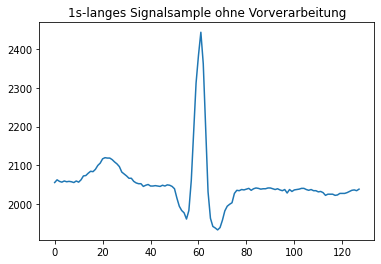

In [ ]:
file_as_dict, subject_dict = load_file(file_path = file_path)

plot_example(subject_dict, "1s-langes Signalsample ohne Vorverarbeitung", is_segmented = False)

### Ausschneidung der Signale
Laut der Arbeit [Dar et al., 2020] und auch dem Artikel aus dem Datensatz [Kat-sigiannis  and  Ramzan,  2018]  ist  der  Einfluss  eines  Gef ̈uhls  nicht  direkt  zu  Beginnder Stimulation dieses Gef ̈uhls aufgetreten. Daher wurde in beiden Forschungsarbei-ten[Katsigiannis and Ramzan, 2018] [Dar et al., 2020] die letzte Minute jedes Stimuli-versuchs benutzt. Zu diesem Zweck wurden die experimentellen Daten als 64-Sekunden-Samples segmentiert, da sie zus ̈atzlich zu den 60 Sekunden einen Versatz von jeweilszwei Sekunden am Anfang und am Ende enthalten.

In [ ]:
shortened_dict = segment_stimuli_signal_from_end(subject_dict, 
                                                 length = signal_length,
                                                 sampling_rate = sampling_rate,
                                                 offset = signal_offset)

### Downsampling
Downsampling ist für meine Arbeit nicht erforderlich, dennoch habe ich es an den Daten durchgeführt, um mit der Zielarbeit ̈ubereinzustimmen. Die Signalabtastrate wurde mittels einer Neurokit-Methode von 256 auf 128 Hz umgeformt. Dar et al. hat dies in ihrer Arbeit mit der Konsistenz zwischen den Daten von Dreamer und dem Amigos-Datensatz erklärt.

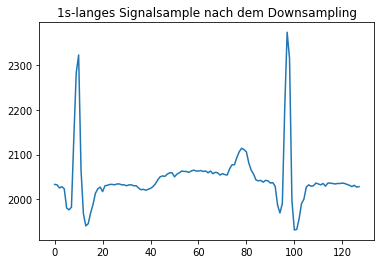

In [ ]:
downsampled_subject_dict = downsampling_ecg_signals(shortened_dict, 
                                                    channel = used_channel, 
                                                    sampling_rate = sampling_rate, 
                                                    desired_sampling_rate = desired_sampling_rate)

plot_example(downsampled_subject_dict, "1s-langes Signalsample nach dem Downsampling", is_segmented = False)

### Tiefpass-Filter
Um das hochfrequente Geräusch aus den Samplesignalen zu entfernen wurden die Signale mit einem Tiefpass-Filter nach dem Butterworth-Verfahren [Butterworth et al.,1930] gefiltert. Durch das Weglassen der Geräusche oberhalb von 60 Hz wurde die Bedeutung der Signale erhöht.

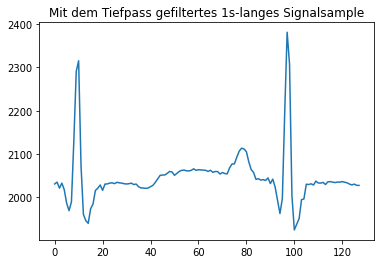

In [ ]:
lowpass_filtered_dict = apply_lowpass_filer(downsampled_subject_dict, 
                                            channel = used_channel, 
                                            sampling_rate = desired_sampling_rate, 
                                            highcut = highcut_of_lowpass)

plot_example(lowpass_filtered_dict, "Mit dem Tiefpass gefiltertes 1s-langes Signalsample", is_segmented = False)

Der Vergleich von abgetasteten und tiefpassgefilterten Signalproben wurde zusammen im folgenden Graph angezeigt.

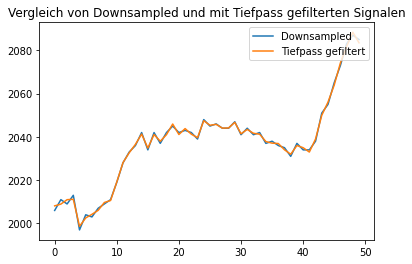

In [ ]:
plt.title("Vergleich von Downsampled und mit Tiefpass gefilterten Signalen")
downsampled_example = downsampled_subject_dict[0]["experiments"][0]["stimuli"]["channel_2"][300:350]
lowpass_example = lowpass_filtered_dict[0]["experiments"][0]["stimuli"]["channel_2"][300:350]
plt.plot(downsampled_example, label = "Downsampled")
plt.plot(lowpass_example, label = "Tiefpass gefiltert")
plt.legend(loc = "upper right")
plt.show()

Danach wurde der Offset-Teil von vorne und hinten abgenommen, um die Wirkung des Filters zu eliminieren. Jedes Signal ist dann eine Sekunde lang mit einer Abtastratevon 128 Hz.

In [ ]:
shortened_filtered_dict = remove_filter_effect_by_edgecutting(lowpass_filtered_dict, 
                                                              offset = signal_offset, 
                                                              sampling_rate = desired_sampling_rate)

### Entfernung vom Baseline

Der Datensatz enthält auch die Basisliniensignale(Baseline-Signals) für jedes Experiment. Dar et al. beschreiben die Entfernung des Baseline-Signals aus den Stimulus-Signalen als ein spezifisches Vorverarbeitungsverfahren für die Emotionsauslösung. Die Grundidee dahinter ist, die Signalinformationen, die den neutralen Zustand darstellen, aus den Daten zu entfernen. Dies erfolgt durch die Berechnung des Durchschnitts von den segmentierten Baseline-Signalen. Die 57 Sekunde langen Baseline-Signale wurden als 1 Sekunde lange Signaleaufgeteilt und ihr Durchschnitt nach der Formel im Bild berechnet. Darin ist m die Anzahl der Segmente und in diesem Fall ist sie 57. BLn ist der Vektor, der das n-te Baseline-Signal darstellt. Die Segmentsignale wurden elementweise summiert  und wiederum elementweise durch die Anzahl der Segmente geteilt. In der Abbildung wurden 5 Segmentsignale mit ihrem Durchschnitt angezeigt.

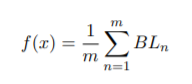



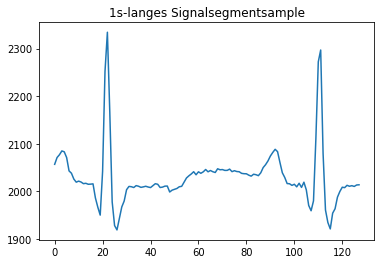

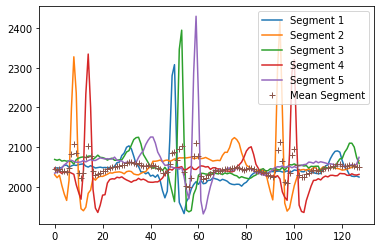

In [ ]:
segmented_dict = get_segmented_dict(shortened_filtered_dict, 
                                    sampling_rate = desired_sampling_rate, 
                                    length_of_segment = segment_length, 
                                    channel = used_channel)

plot_example(segmented_dict, "1s-langes Signalsegmentsample", is_segmented = True)
plot_baseline_example()

Die 60-Sekunden-Stimulusdaten wurden ebenfalls in 1-Sekunden-Segmente augeteilt.
Das Durchschnittssignal von Baseline-Signalen wurde aus den entsprechenden Stimulisignalsegmenten nach der Formel im Bild entfernt, wobei k das k-te Stimulisignalsegment bezeichnet. In der Abbildung wurde ein Stimulisignalsegment nach der Entfernung des Baseline-Durchschnittssignals in Verfugung gestellt.

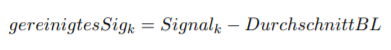

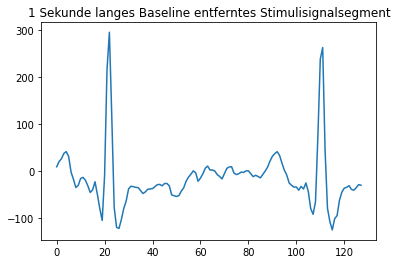

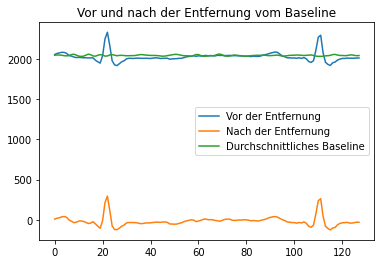

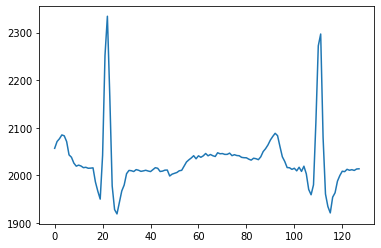

In [ ]:
baseline_removed_dict = remove_baseline_from_stimuli(segmented_dict,
                                                     channel = used_channel)
plot_example(baseline_removed_dict, "1 Sekunde langes Baseline entferntes Stimulisignalsegment", is_segmented = True)

plt.title("Vor und nach der Entfernung vom Baseline")
with_baseline = segmented_dict[0]["experiments"][0]["stimuli"]["segments"]["segment_0"]
mean_segment = segmented_dict[0]["experiments"][0]["baseline"]["mean_segment"]
after_removal = baseline_removed_dict[0]["experiments"][0]["stimuli"]["segments"]["segment_0"]
plt.plot(with_baseline, label = "Vor der Entfernung")
plt.plot(after_removal, label = "Nach der Entfernung")
plt.plot(mean_segment, label="Durchschnittliches Baseline")
plt.legend(loc = "best")
plt.show()

plt.plot(with_baseline)
plt.show()

### Standardisierung der Daten

Das Standardisierungsverfahren, auch Z-Score-Normalisierung [Bhanja and Das, 2018]genannt, formt seine Eingabedaten so um, dass die Daten einen Durchschnittswert von 0 und eine Standardabweichung von 1 haben. Dank der Skalierung bieten Deep-Learning-Modelle oft eine höhere Leistung als Daten, die stark variieren, d. h. Daten mit geringer Variationsbreite [Géron, 2019]. Hierfür habe ich den StandartScaler aus der Scikit-Bibliothek [Pedregosa et al., 2011] verwendet. In der befolgten Arbeit [Dar et al., 2020] wurden die Daten auch nach der Z-Score-Normalisierung skaliert. Wie inder Arbeit wurde auch hier jedes Segment aus den Trainings- und Testdaten auf dieseWeise skaliert und in der Abbildung wurde ein Beispiel gezeigt, bei dem die Datenzwischen -2 und 5 liegen.

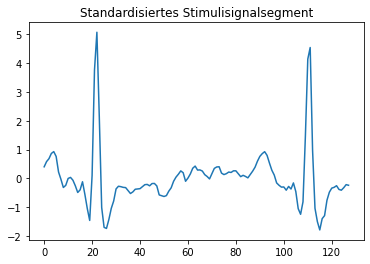

In [ ]:
standardized_dict = standardize_stimuli_signals(baseline_removed_dict)
plot_example(standardized_dict, "Standardisiertes Stimulisignalsegment", is_segmented = True)

### Bereitstellung der Labels

Dar et al. haben bei ihrer Arbeit die Selbstbewertungspuppe(SAM)[Morris, 1995] für die Labelssetzung verwendet. In der SelfAssessment Manikin (SAM) erfolgte die Bewertung und Bestimmung eines Gefühls in der Regel anhand einer 9-Punkte-Skala. Im Gegensatz dazu erfolgte die Bestimmung des Gefühls im Dreamer-Datensatz anhand einer 5-Punkte-Skala. Daher wurde der Schwellwert als 3 eingesetzt, um die Labels in die binäre Form zu konvertieren, die so
genannte One-Hot-Codierung. Zum Beispiel hat ein Sample mit dem Erregungswert
von 2 und dem Valenzwert von 4 das Label LAHV, das fur geringe Erregung(Low-Arousal), hohe Valenz(High-Valence) steht. Die Labelsetzungslogik kann nach der Formel im Bild beschrieben werden, wobei e, v die Erregungs- bzw. Valenzwerte darstellen.

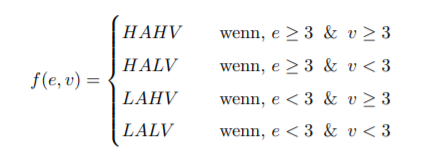

In [ ]:
label_set, labeled_dict = label_segments(standardized_dict, 
                                         file_as_dict,
                                         threshold= label_threshold)

### Zusammenfassung des vorverarbeiteten Datensatzes

Nach der Vorverarbeitung enth¨alt der Datensatz 24.840 Samples(23 Teilnehmer x 18 Experimente x 60 Segmenten) mit 3.179.520 Datenpunkte(24.840 Samples x 128 Hz). Jedes Sample hat die Form (1x128), die ein 1-Sekunden langes Stimulus-Signalsample und sein Label enthält. Die Anzahl jedes Labels wurde in der Abbildung angezeigt.

In [ ]:
data_df = change_data_structure(labeled_dict, 
                                data_structure = "dataframe")

report_summary(standardized_dict)

For one subject:
Num of experiments: 18
For one experiment:
Num of stimuli signal segments:60
For one stimuli segment:
Num of timesteps: 128
----------------------
Total:
Subject count: 23
Experiment count: 414
Num of samples (Segment count): 24840


In [ ]:
# Entfernung der vorherigen Logs
rm -rf ./logs/

In [ ]:
# Bereitstellung der Zufälligkeitsvariablen, um die Ergebnisse der wiederholten Versuche nah zu bekommen
# und Einstellung des Tensorboards
random_state = 100

seed(random_state)
np.random.seed(random_state)
random.set_seed(random_state)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Deep Learning

## Auswahl des Modell- und Versuchtyps

Jeder Versuch wurden mit den ähnlichen Trainingsparametern durchgeführt und die Unterschiede wurden unter dem entsprechenden Teil angegeben. Die Stapelgröße von
Eingaben wurde als 240 festgelegt, die anfängliche lernrate als 0.001, das Lernalgorithmus als ADAM. Der Datensatz wurde als Trainings- und Testdaten in zwei Teilen 70 % und bzw. 30 % eingeteilt.

Wenn das Modelltyp als "cnn-lstm" eingesetzt wird;

> Das Modell von der Arbeit[Dar et al., 2020] wurde wie erwähnt übernommen. Ein
CNN-LSTM-Modell ist gut geeignet für die Probleme wie Filmklassifizierung, weil der CNN-Teil des Modells für die Bilderdaten und der LSTM-Teil für die sequentiellen Daten nützlich ist. Das Hauptziel bei der Zusammenführung der beiden Teile ist die Extraktion der Merkmale aus den Bilddaten durch den CNN-Teil und des zeitabhängigen Merkmalsraums aus diesen sequenzbildenden Daten durch den LSTM-Teil des Netzwerks. Es wird dann ermöglicht, durch zusätzliche Dense-Schichten die Klassifikation dieser Merkmale auszuführen.
Die Signaldaten könnten auch wie ein Bild betrachtet werden, dadurch, dass ihre
Form (als 128x1x1) neu angeordnet wird. Ein Bild kann durch eine drei-dimensionale Matrix dargestellt werden, die der Höhe bzw. der Breite und der Anzahl der Kanäle entspricht. In diesem Fall entspricht die Form eines Samples der Länge der Sequenz, der Höhe bzw. der Anzahl der Merkmale. In Keras entwickelte Modell benötigt die Form 1x128x1x1.

Wenn der Modelltyp als "only-cnn" eingesetzt wird;


> Die Bilder werden oft durch die CNN-Modelle klassifiziert. Kürzlich erregt ihr Erfolg bei der Klassifizierung der Zeitfolgedaten Aufmerksamkeit. Zhao et al. hat berichtet, dass für solche Probleme ein CNN-Modell die charakteristische und komplexere Merkmalen aus den Zeitfolgedaten extrahieren kann. Normalerweise werden die Merkmale vor einem maschinellen Lernprozess durch verschiedene Extraktionsmethoden in der Vorverarbeitung ermittelt [Kundinger et al., 2020a] [Kundinger and Riener, 2020]. In
diesem Versuch habe ich ein 1D-CNN-Modell verwendet, dadurch, dass die Filter sich auf der Zeitachse verschieben. Im 1D-CNN-LSTM-Modell von Dar et al. wurde keine Aktivierungsfunktion für die letzten drei Dense-Schichten angegeben. Ohne eine spezifische Aktivierungsfunktion wählt das Modell die lineare Aktivierungsfunktion als Standard, und anstatt komplexere Muster zu erkennen, bildet das Modell eine lineare Beziehung zwischen den Eingaben und Ausgaben ab [Nwankpa et al., 2018]. Dies kann fur ein tiefes Modell nützlich sein, wenn die komplexeren Merkmale bereits vorher extrahiert worden sind. Andererseits können die Dropout-Schichten uns bei der Überanpassung helfen, aber in dieser Arbeit möchte ich die Leistung des Modells ohne Dropout-Schichten überprüfen. Das Modell benötigt eine Eingabeform von 128×1x1. In diesen Versuchen mit dem CNN-Modell habe ich den gleichen beta 2-Wert für das ADAM-Lernalgorithmus vererbt und das Modell wurde wieder für 70 Epoche trainiert.

Wenn der Modelltyp als "only-lstm" eingesetzt wird;

> Die LSTM-Modelle werden häufig für die Probleme wie Zeitfolgeklassifikation verwendet. Obwohl ein LSTM-Modell bei Zeitfolgedaten gute
Ergebnisse liefern kann, ist seine Leistung bei langen Zeitfolgedaten meist gering [Géron, 2019]. Das Training eines LSTM-Modells dauert relativ länger im Vergleich zu den anderen vorgestellten Modellen wegen seiner Rechnungskomplexität. Deswegen habe ich in den Versuchen mit 1D-CNN-LSTM-Modell zuerst die Merkmale mit dem CNN-Teil des Modells extrahiert, dann wurden sie in den LSTM-Teil eingegeben. Dadurch wird der Eingaberaum des LSTM-Teils verkleinert und das Training beschleunigt, so dass das LSTM nur die zeitabhängige Beziehung zwischen extrahierten Merkmalen klassifiziert und in diesem Merkmalsraum nach einem Muster sucht.In den folgenden Versuchen habe ich nur ein LSTM-Modell verwendet, das in Bezug auf den Modellentwurf ähnlich dem CNN-Modell aussieht. Das Modell besteht aus zwei LSTM-Schichten mit 128 und bzw.
64 versteckten Knoten, die für die Zustandsaktivierungsfunktion ”tanh“ und für die Gatter-Aktivierungsfunktion ”Sigmoid“ verwenden. Das Modell erfordert die Eingabeform als None × 1, weil ein LSTM-Modell mit den Zeitfolgedaten mit unbestimmter Länge funktionieren kann, und 1 beschreibt die Anzahl von Merkmalen. Anstatt nur die letzte Ausgabe der ersten LSTM-Schicht an
die nächste Schicht weiterzugeben, gibt die erste Schicht alle ihre Ausgaben, d. h. die Ausgaben jedes Knotens dieser Schicht, an die nächste Schicht weiter. Danach gehen die Ausgaben der letzten LSTM-Schicht durch den Dense-Teil des Netzwerkes durch. Für beide Versuche wurde der Wert für beta_2 mit 0,99 angesetzt und damit auf seinen Defaultwert zuruckgesetzt. Das Modell wurde mit dem ADAM-Lernalgorithmus für 70 Epoche trainiert.


Mit folgenden Versuchstypen wird die Widerstandsfähigkeit dieser Modelle in Bezug auf die Benutzerabhängigkeit der Daten untersucht.

Wenn der Versuchstyp durch den Variable userdependent als "True" eingesetzt wird;

> Die Eingaben werden in 70% Trainings- und 30% Testdaten nach dem Zufallsprinzip eingeteilt.

Wenn der Versuchstyp durch den Variable userdependent als "False" eingesetzt wird;

> Die Daten von 16 Teilnehmer werden für das Training und der Rest werden für das Testen verwendet.












In [ ]:
model_type = "cnn-lstm"
batch_size = 240
userdependent = False
if model_type != "only-lstm":
  beta_2 = 0.99
else: 
  beta_2 = 0.999
print("Selected beta_2: " + str(beta_2))
X_train, Y_train, X_test, Y_test = reshape_data_for_model(data_df, model_type = model_type, random_state=random_state, user_dependent=userdependent)
encoded_Y_train, encoded_Y_test = encode_labels(Y_train, Y_test)
print("Encoded train label shape: " + str(encoded_Y_train.shape))
model = build_model(model_type)

Selected beta_2: 0.99
---Input shapes---
X_train: (17280, 1, 128, 1, 1)
X_test: (7560, 1, 128, 1, 1)
Y_train: (17280, 1)
Y_test: (7560, 1)
------------------------------
Encoded train label shape: (17280, 4)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 1, 128, 1, 16)     64        
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 128, 1, 16)     0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 1, 128, 1, 32)     1568      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 1, 128, 1, 32)     0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 1, 4096)           0         
____________________________________________

## Trainieren das Modell

Im Training werden 10% der Trainingsdaten für die Validierung verwendet. Das Modell wird für 70 Epochen trainiert.

Um seine Schätzungen zu verbessern, muss das Modell zuerst seinen Fehler rechnen und dann ihn zu vermindern. Die Verlustfunktion Categorical-Cross-Entropy gibt uns den Fehler an, indem sie die Schätzungen mit den wahren Werten der Labels vergleicht. Betrachtet man die folgende Formel, so funktioniert sie sowohl für binäre Klassen als auch für Multiklassen. Darin ist m die Anzahl der Samples und K beschreibt die Anzahl der Klassen. Somit entspricht y_k^i der k-ten Klasse von dem i-ten Sample und hat(p)_k^i der durch das Modell geschätzten Wahrscheinlichkeit dieser Klasse [Géron, 2019].

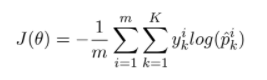

Um die Genauigkeit eines Modells zu bewerten, kann die kategoriale Genauigkeitsmetrik (Categorical-Accuracy) für die Multiklassen-Klassifizierungsprobleme verwendet werden, die gemäß der Implementation [Abadi  et  al.,  2015] die Anzahl der korrekt geschätzten Labels durch die Gesamtanzahl der Labels teilt. Sie kann durch die folgende Formel definiert werden.

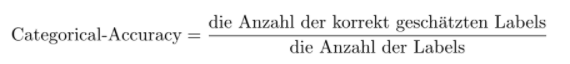



In [ ]:
model.compile(optimizer = keras.optimizers.Adam(beta_2=beta_2), 
              loss = keras.losses.CategoricalCrossentropy(), 
              metrics = "categorical_accuracy")
model.fit(X_train,
          encoded_Y_train,
          batch_size=batch_size,
          epochs=70,
          verbose=1,
          validation_split=0.1,
          callbacks=[tensorboard_callback])

# Evaluierung des Modells

Das Modell wird in Bezuf auf Trainings- und Testdaten mit Categorical-Accuracy evaluiert.

In [ ]:
evaluate_mode_train_and_test(model, X_train, encoded_Y_train, X_test, encoded_Y_test, batch_size=batch_size)

Das Modell im Trainingsphase kann durch Tensorboard untersucht werden.

In [ ]:
%tensorboard --logdir logs/fit

Die Modellstruktur kann wie folgt angezeigt werden.

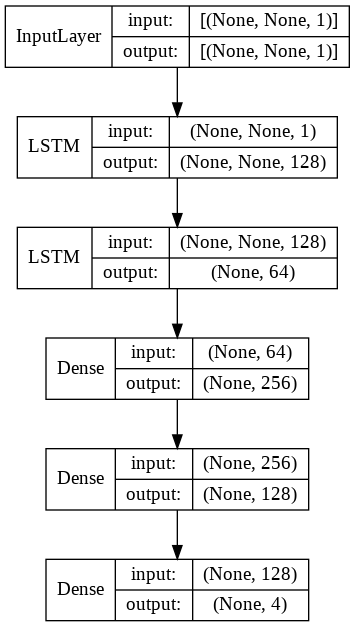

In [ ]:
tf.keras.utils.plot_model(model, to_file="model-image.png", show_shapes=True, show_layer_names=False)

Die Bewertung eines Modells mit nur einer Metrik kann uns zu einem falschen Gefühl der Korrektheit verleiten.  Wenn ein Modell beispielsweise ein Overfitting (eine Überanpassung) aufweist, d. h. statt die Merkmale zu lernen, hat es sich eine Klasse eingeprägt, kann das Modell auch bei den Testdaten, die zu dieser Klasse gehören, gute Leistungen erbringen. Deswegen muss das Modell auch unter verschiedenen Aspekten bewertet werden.

Die Schätzungen werden sowohl für die Trainings- als auch für die Testdaten bekommt, um die weitere Metriken zu erhalten. 

In [ ]:
train_pred, test_pred = get_predictions(model, X_train, X_test, label_set)

Da kann die Confusion-Matrix hilfreich sein, die auf der einen Seite die Anzahl der korrekten Labels und auf der anderen Seite die Anzahl der geschätzten Labels enthält. Damit ermöglicht uns die Anzahl der richtig klassifizierten Daten und die Verteilung der Schätzungen zu untersuchen [Ting, 2017]. Eine Confusion-Matrix kann wie in der Abbildung dargestellt werden, darin steht "TP" für die richtig geschätzten positiven Labels, "FP" für die falsch geschätzten, wobei weiterhin "FP" für falsch geschätzten negativen Labels steht, "TN" für richtig geschätzten.

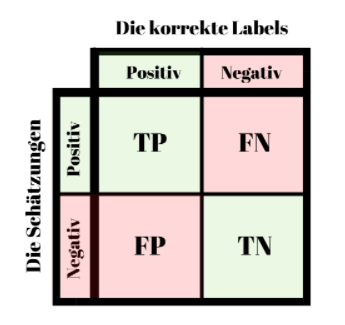

In folgender Abbildung wird die Confusionmatrize mit den Schätzungen für Trainingsdaten angezeigt. 

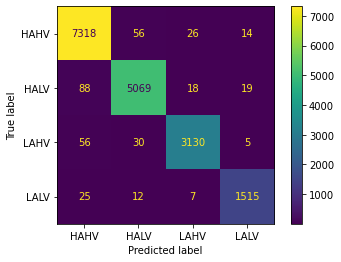

In [ ]:
plot_confusion_matrix(Y_train, train_pred, label_set)

In folgender Abbildung wird die Confusionmatrize mit den Schätzungen für Testsdaten angezeigt. 

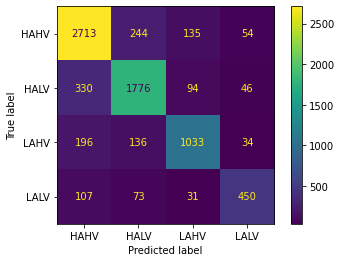

In [ ]:
plot_confusion_matrix(Y_test, test_pred, label_set)

Obwohl man viel aus der Konfusionsmatrix lernen kann, braucht man manchmal mehr Metriken. Eine davon ist der Präzisionswert(Precision). Die Präzision stellt den Anteil der als positiv geschätzte Samples vor, die richtig geschätzt werden. Also, beantwortet dies die Frage „Wie viel von positive Einschätzungen sind eigentlich positiv?“. Sie wird mithilfe von der Confusion-Matrix durch die Formel definiert [Géron, 2019].

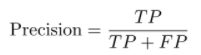

Wenn das Modell nur eine positive Schätzung hat, die korrekt ist, wird der \linebreak Präzisionswert 1, auch wenn die restlichen Schätzungen falsch-negativ sind. Nur den Präzisionswert zu berücksichtigen, ist nicht so sinnvoll. Deshalb wird der Präzisionswert oft zusammen mit dem Rückrufswert(das Recall) betrachtet. Der Rückrufswert beantwortet die Frage „Wie viel von richtig positive Einschätzungen wurden richtig eingeschätzt?“. Seine Formel sieht wie in der Gleichung [Géron, 2019].

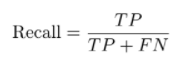

Es ist sehr nützlich, diese beiden Metriken zusammen zu analysieren. Dennoch gibt es einen Abtausch zwischen der Präzision und dem Rückruf. Um diese Metriken zusammen im Betracht zu nehmen, steht F1-Score in Verfügung und durch die Gleichung errechnet.

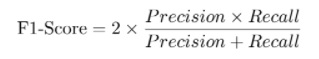

Wenn ein Datensatz unausgewogen ist, kann der Durchschnitt der Bewertungsmetriken mit der Multiplikation verschiedener Gewichte, die dem Anteil der Klassen entsprechen, berechnet werden, d. h. gewichteter Durchschnitt(Weighted-Average). Der normale Durchschnitt wird auch Makro-Durchschnitt(Macro-Average) genannt.

In [ ]:
get_classification_report(Y_train, train_pred, Y_test, test_pred)

Train report:
              precision    recall  f1-score   support

        HAHV       0.98      0.99      0.98      7414
        HALV       0.98      0.98      0.98      5194
        LAHV       0.98      0.97      0.98      3221
        LALV       0.98      0.97      0.97      1559

    accuracy                           0.98     17388
   macro avg       0.98      0.98      0.98     17388
weighted avg       0.98      0.98      0.98     17388

*********************
Test report:
              precision    recall  f1-score   support

        HAHV       0.81      0.86      0.84      3146
        HALV       0.80      0.79      0.79      2246
        LAHV       0.80      0.74      0.77      1399
        LALV       0.77      0.68      0.72       661

    accuracy                           0.80      7452
   macro avg       0.79      0.77      0.78      7452
weighted avg       0.80      0.80      0.80      7452



# Diskussion über den Ergebnissen

In den Tabellen 4.8 und 4.9 wurden die besten Ergebnisse fett gedruckt. Dies sind die höchst-erreichte Genauigkeit bzw. die besten F1-Scores der Klassen in Bezug auf die entsprechende Versuche.

Wie in der Tabelle 4.8 veranschaulicht, hat das 1D-CNN-LSTM Modell die höchste Genauigkeit für beide Arten von Versuchen hervorgebracht und ist mit dem unbalancierten Datensatz besser zurechtgekommen. Wenn klassenweise untersucht wurde, hat sich das Modell im ersten Versuch bei keiner Klasse überangepasst. Im Gegensatz zu seiner Performanz auf benutzerabhängigen Daten hat das Modell geringere Resisdenz gegenüber der benutzerunabhängigen Verteilung der Daten. Obwohl es wieder die höchste Genauigkeit erreicht hat, konnte das Modell die Klassen nicht so gut voneinander unterscheiden. Wahrscheinlich liegt das daran, dass das Modell statt klassenbezogener Merkmale die personenbezogenen Merkmale gelernt hat.

Ich habe eigentlich nicht erwartet, dass sich auch die Trainingsgenauigkeiten der entsprechenden Modelle je nach Versuch voneinander unterscheiden. Zusätzlich zur Veränderung der Datenverteilung hat sich auch die Reihenfolge der Daten geändert, die Menge an Trainings- bzw. Testdaten blieb aber ähnlich. Es könnte auch sein, dass das Modell zuerst die personenbezogenen Merkmale lernt und dann für die jeweiligen Personen ihren Gefühlszustand erkennt. In diesem Fall hat das Modell im benutzerabhängigen Versuch die Erfahrungen wahrscheinlich an jedem Zustand der Person mindestens einmal gesammelt und damit in Bezug auf ihrer Ähnlichkeit die Klasse voneinander unterschieden. Dagegen ist die Vielfältigkeit der Daten im benutzerunabhängigen Versuch verloren gegangen, weil das Modell keine Samples von jedem Teilnehmer gesehen hat. 

Das CNN-Modell hat auch ähnliche Ergebnisse geliefert, aber mit höherer Überanpassung. Es ist erwähnenswert, dass das 1D-CNN-LSTM- und das CNN-Modell für beide Versuche die gleiche Genauigkeit sowohl im Training als auch im Testen mit benutzerunabhängigen Daten erreicht haben. 

In dieser Arbeit wurde festgestellt, dass ein LSTM-Modell für dieses Problem nicht sehr gut geeignet ist und die komplexeren Merkmale nicht extrahieren kann. Trotzdem haben das LSTM-Modell und das CNN-Modell im Versuch mit benutzerunabhängigen Daten bessere Ergebnisse erzielt als das 1D-CNN-LSTM-Modell für die Unterscheidung der Klassen. In Bezug auf seine klassenbasierte Leistung hat das LSTM-Modell den gleichen F1-Score für die Klasse „HAHV“ und „HALV“ erreicht, und zwar das beste Ergebnis aller drei betrachteten Modelle für die Klasse „HALV“. Die schwierigste geschätzte Klasse „LALV“ wurde am besten vom CNN-Modell, und die Klasse „LAHV“ wurde am besten von den CNN- und LSTM-Modellen erkannt. 

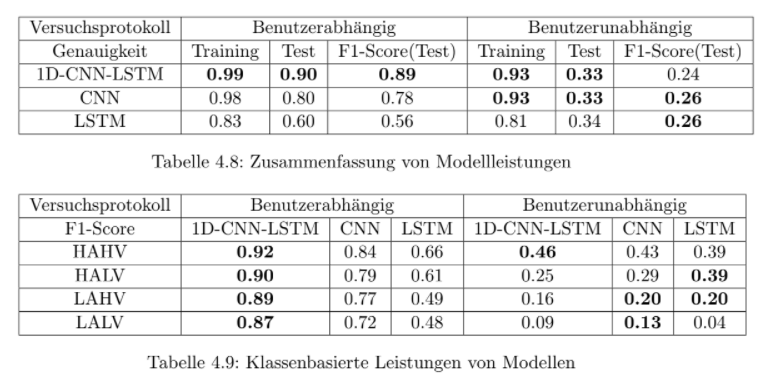

Diese Arbeit gehört zur Bachelorarbeit von Deniz Mert Tecimer zur Erkennen von Gefühlen aus physiologischen Daten von EKG-Gerät mithilfe von Deep-Learning-Methoden.

*   S. Katsigiannis and N. Ramzan. Dreamer: A database for emotion recognition through eeg and ecg signals from wireless low-cost off-the-shelf devices. IEEE Journal of Biomedical and Health Informatics, 22(1):98–107, 2018. doi: 10.1109/JBHI.2017. 2688239.
 
*   C. Gabert-Quillen, E. Bartolini, B. Swerdlow, and C. Sanislow. Ratings for emotion film clips. Behavior research methods, 47, 07 2014. doi: 10.3758/s13428-014-0500-0.

*   M. N. Dar, M. U. Akram, S. G. Khawaja, and A. N. Pujari. Cnn and lstm-based
emotion charting using physiological signals. Sensors, 20(16), 2020. ISSN 1424-8220. doi: 10.3390/s20164551. URL https://www.mdpi.com/1424-8220/20/16/4551.

*   S. Butterworth et al. On the theory of filter amplifiers. Wireless Engineer, 7(6): 536–541, 1930.

*   S. Bhanja and A. Das. Impact of data normalization on deep neural network for time series forecasting. arXiv preprint arXiv:1812.05519, 2018.

*   A. Géron. Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems. O’Reilly Media, 2019.

*   F. Pedregosa, G. Varoquaux, A. Gramfort, V. Michel, B. Thirion, O. Grisel, M. Blondel, P. Prettenhofer, R. Weiss, V. Dubourg, J. Vanderplas, A. Passos, D. Cournapeau, M. Brucher, M. Perrot, and E. Duchesnay. Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12:2825–2830, 2011.

*   J. D. Morris. Observations: Sam: The self-assessment manikin an efficient cross-cultural measurement of emotional response 1. Journal of Advertising Research, 1995.

*   T. Kundinger, N. Sofra, and A. Riener. Assessment of the potential of wrist-worn wearable sensors for driver drowsiness detection. Sensors, 20(4), 2020a. ISSN 1424-8220. doi: 10.3390/s20041029. URL https://www.mdpi.com/1424-8220/20/4/1029.

*   T. Kundinger and A. Riener. The potential of wrist-worn wearables for driver
drowsiness detection: A feasibility analysis. In Proceedings of the 28th ACM
Conference on User Modeling, Adaptation and Personalization, UMAP ’20, page
117–125, New York, NY, USA, 2020. Association for Computing Machinery. ISBN 9781450368612. doi: 10.1145/3340631.3394852. URL URL https://doi.org/10.1145/340631.3394852.

*   C. Nwankpa, W. Ijomah, A. Gachagan, and S. Marshall. Activation functions: Comparison of trends in practice and research for deep learning. ArXiv, abs/1811.03378, 2018.

*   M. Abadi, A. Agarwal, P. Barham, E. Brevdo, Z. Chen, C. Citro, G. S. Corrado, A. Da-
vis, J. Dean, M. Devin, S. Ghemawat, I. Goodfellow, A. Harp, G. Irving, M. Isard, Y. Jia, R. Jozefowicz, L. Kaiser, M. Kudlur, J. Levenberg, D. Man ́e, R. Monga, S. Moore, D. Murray, C. Olah, M. Schuster, J. Shlens, B. Steiner, I. Sutskever, K. Talwar, P. Tucker, V. Vanhoucke, V. Vasudevan, F. Vi ́egas, O. Vinyals, P. Warden, M. Wattenberg, M. Wicke, Y. Yu, and X. Zheng. TensorFlow: Large-scale machine learning on heterogeneous systems, 2015. URL https://www.tensorflow.org/. Software available from tensorflow.org.

*   K. M. Ting. Confusion Matrix, pages 260–260. Springer US, Boston, MA, 2017. ISBN 978-1-4899-7687-1. doi: 10.1007/978-1-4899-7687-1 50. URL https://doi.org/10. 1007/978-1-4899-7687-1_50.













